# Report for Homework 3

In [3]:
!nvidia-smi

Tue Apr  1 18:55:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:42:00.0 Off |                  Off |
|  0%   28C    P8             12W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install requirements

In [1]:
!pip install torch -q
!pip install torchvision -q
!pip install opencv-python -q
!pip install tqdm -q
!pip install matplotlib -q
!pip install albumentations -q

In [ ]:
import os
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

/root/hw3/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    num_workers = 1
elif torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = torch.cuda.device_count() - 1
else:
    device = torch.device("cpu")
    num_workers = os.cpu_count() - 1

params = {
    "device": device,
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": num_workers,
    "epochs": 30, 
    "weight_decay": 1e-4,
    "early_stopping_patience": 5,
    "image_size": 256, 
}

print(params)

{'device': device(type='cuda'), 'lr': 0.001, 'batch_size': 32, 'num_workers': 0, 'epochs': 30, 'weight_decay': 0.0001, 'early_stopping_patience': 5, 'image_size': 256}


## Data pre-processing and processing

### Load data

In [34]:
root_dir = "./data"
images_dir = os.path.join(root_dir, "images")
masks_dir = os.path.join(root_dir, "masks")

images_filepaths = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
masks_filepaths = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])

print(f"images_filepaths len: {len(images_filepaths)}")
print(f"masks_filepaths len: {len(masks_filepaths)}")

images_filepaths len: 274
masks_filepaths len: 274


### Validate images

In [35]:
def is_valid_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"Invalid image: {filepath}")
        return False
    return True
    
def validate_images(image_paths):
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(tqdm(executor.map(is_valid_image, image_paths), total=len(image_paths), desc="validating images"))
    valid_images = [path for path, result in zip(image_paths, results) if result]
    return valid_images

valid_images = validate_images(images_filepaths)
valid_masks = validate_images(masks_filepaths)

images_with_masks = [(image, mask) for image, mask in zip(images_filepaths, masks_filepaths) if image in valid_images and mask in valid_masks]

print(f"images_with_masks len: {len(images_with_masks)}")

Invalid image: ./data/images/0.jpg


validating images: 100%|██████████| 274/274 [00:00<00:00, 1660.34it/s]

images_with_masks len: 273


### Plot image size distribution

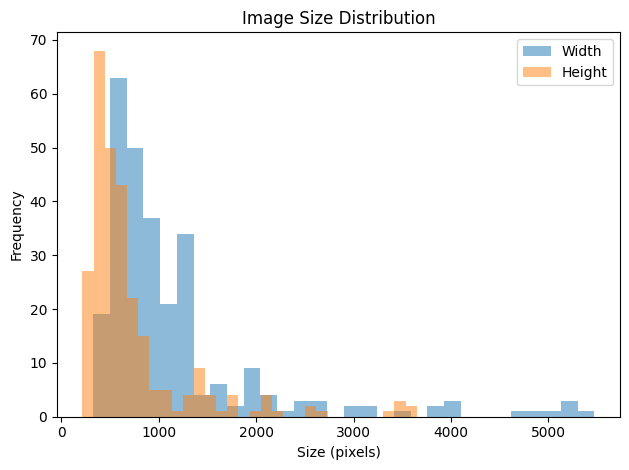

In [36]:
def analyze_image_sizes(image_paths):
    image_sizes = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            image_sizes.append((w, h))
    return image_sizes

def plot_image_size_distribution(image_sizes):
    widths, heights = zip(*image_sizes)

    plt.hist(widths, bins=30, alpha=0.5, label='Width')
    plt.hist(heights, bins=30, alpha=0.5, label='Height')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

image_sizes = analyze_image_sizes(valid_images)
plot_image_size_distribution(image_sizes)

### Train-test split

In [37]:
# do 80/10/10 split
random.shuffle(images_with_masks)

train_size = int(0.8 * len(images_with_masks))
val_size = int(0.1 * len(images_with_masks))

train_images_with_masks = images_with_masks[:train_size]
val_images_with_masks = images_with_masks[train_size:train_size + val_size]
test_images_with_masks = images_with_masks[train_size + val_size:]

print(f"train_images_with_masks len: {len(train_images_with_masks)}")
print(f"val_images_with_masks len: {len(val_images_with_masks)}")
print(f"test_images_with_masks len: {len(test_images_with_masks)}")

train_images_with_masks len: 218
val_images_with_masks len: 27
test_images_with_masks len: 28


### Load Dataset with DataLoader 

In [38]:
class FloodDataset(Dataset):
    def __init__(self, images_filepaths, masks_filapaths, transform=None):
        self.images_filepaths = images_filepaths
        self.masks_filapaths = masks_filapaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)
    
    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        mask_filepath = self.masks_filapaths[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE) # load in grayscale

        if self.transform:
            # as it is semantic segmentaion one must perform the same transform for image and its corresponding mask 
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

            # convert mask to binary (0 or 1) for BCE loss
            if isinstance(mask, torch.Tensor):
                mask = mask / 255.0 if mask.max() > 1.0 else mask

        return image, mask, image_filepath, mask_filepath # filepath for debugging

### Augmentations

In [ ]:
train_transform = A.Compose([
    A.PadIfNeeded(min_height=params["image_size"], min_width=params["image_size"], border_mode=cv2.BORDER_CONSTANT),
    A.Resize(params["image_size"], params["image_size"]),
    
    A.RandomResizedCrop(size=(params["image_size"], params["image_size"]), 
                        scale=(0.9, 1.0),
                        ratio=(0.95, 1.05), 
                        p=0.5),
    
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=10, p=0.4),
    A.ElasticTransform(alpha=80, sigma=80 * 0.05, p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=0.5),
    
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1.0),
        A.RGBShift(r_shift_limit=10, g_shift_limit=7, b_shift_limit=7, p=1.0),
        A.ToSepia(p=0.5),
    ], p=0.6),
    
    A.OneOf([
        A.GridDistortion(num_steps=4, distort_limit=0.03, p=1.0),
        A.OpticalDistortion(distort_limit=0.03, p=1.0),
    ], p=0.15),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], is_check_shapes=False)


val_transform = A.Compose([
    A.PadIfNeeded(min_height=params["image_size"], min_width=params["image_size"], border_mode=cv2.BORDER_CONSTANT),
    A.Resize(params["image_size"], params["image_size"]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
],is_check_shapes=False)

test_transform = A.Compose([
    A.PadIfNeeded(min_height=params["image_size"], min_width=params["image_size"], border_mode=cv2.BORDER_CONSTANT),
    A.Resize(params["image_size"], params["image_size"]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
],is_check_shapes=False)

/root/hw3/venv/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [40]:
train_dataset = FloodDataset(
    [img for img, _ in train_images_with_masks],
    [mask for _, mask in train_images_with_masks],
    transform=train_transform
)

val_dataset = FloodDataset(
    [img for img, _ in val_images_with_masks],
    [mask for _, mask in val_images_with_masks],
    transform=val_transform
)

test_dataset = FloodDataset(
    [img for img, _ in test_images_with_masks],
    [mask for _, mask in test_images_with_masks],
    transform=test_transform
)

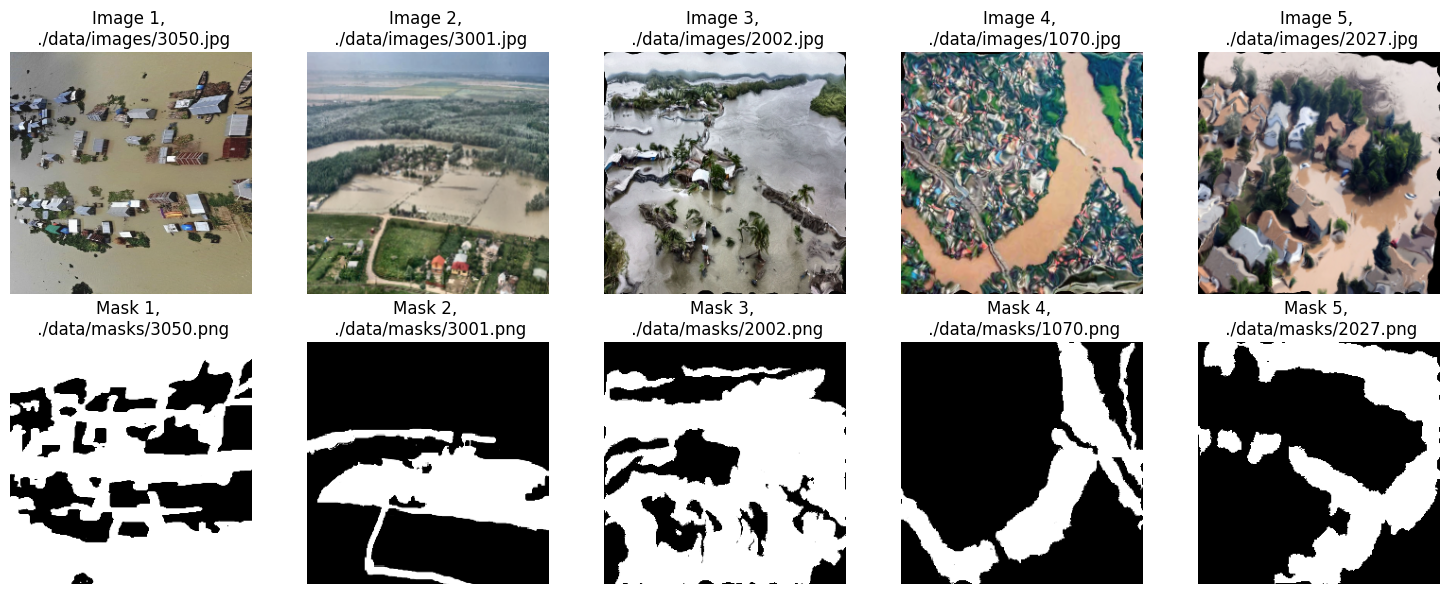

In [41]:
def visualize_augmentations(dataset, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([
        t for t in dataset.transform if not isinstance(t, (ToTensorV2, A.Normalize)) # remove ToTensorV2 and Normalize
    ])
    fig, axes = plt.subplots(2, samples, figsize=(samples * 3, 6))
    for i in range(samples):
        image, mask, image_filepath, mask_filepath = dataset[i]
        axes[0, i].imshow(image)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Image {i+1}, \n {image_filepath}")
        axes[1, i].imshow(mask, cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Mask {i+1}, \n {mask_filepath}")
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_dataset, samples=5)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True)

## Experiment log

### Training Pipeline

In [ ]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1, backbone="resnet101"):
        super(DeepLabV3Plus, self).__init__()
        if backbone == "resnet50":
            self.backbone = deeplabv3_resnet50(pretrained=True, progress=True)
        elif backbone == "resnet101":
            self.backbone = deeplabv3_resnet101(pretrained=True, progress=True)
        elif backbone == "mobilenet_v3_large":
            self.backbone = deeplabv3_mobilenet_v3_large(pretrained=True, progress=True)
        else:
            raise ValueError("Invalid backbone name. Choose from 'resnet50', 'resnet101', or 'mobilenet_v3_large'.")
        self.backbone.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        
    def forward(self, x):
        result = self.backbone(x)["out"]
        return torch.sigmoid(result)
    
def dice_coefficient(pred, target, smooth=1.0):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        return 1 - dice_coefficient(pred, target, self.smooth)
    
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce

class BoundaryLoss(nn.Module):
    def __init__(self, kernel_size=3):
        super(BoundaryLoss, self).__init__()
        self.kernel_size = kernel_size
        
    def forward(self, pred, target):
        laplacian_kernel = torch.tensor([
            [-1, -1, -1],
            [-1,  8, -1],
            [-1, -1, -1]
        ], dtype=torch.float32).view(1, 1, 3, 3).to(pred.device)
        pred_boundaries = F.conv2d(pred, laplacian_kernel, padding=1)
        target_boundaries = F.conv2d(target, laplacian_kernel, padding=1)        
        boundary_loss = F.mse_loss(pred_boundaries, target_boundaries)
        return boundary_loss
    
class BoundaryAwareDiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.3, boundary_weight=0.2):
        super(BoundaryAwareDiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.boundary_weight = boundary_weight
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        self.boundary_loss = BoundaryLoss()
        
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        boundary = self.boundary_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce + self.boundary_weight * boundary  

In [ ]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    best_val_dice = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks, _, _ in train_loop:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            dice = dice_coefficient(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks).item()
            
            train_loss += loss.item()
            train_dice += dice
            
            train_loop.set_postfix(loss=loss.item(), dice=dice)
        
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for images, masks, _, _ in val_loop:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                if outputs.shape[2:] != masks.shape[1:]:
                    outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                
                loss = criterion(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks)
                
                dice = dice_coefficient(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks).item()
                
                val_loss += loss.item()
                val_dice += dice
                
                val_loop.set_postfix(loss=loss.item(), dice=dice)
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        
        if scheduler:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), f"best_model_{model_name}.pth")
            print(f"Saved best model with Dice score: {best_val_dice:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= params["early_stopping_patience"]:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    return model, history

def evaluate_model(model, test_loader, criterion, use_tta=False, use_crf=False, device=params["device"]):
    model.eval()
    test_loss = 0.0
    test_dice = 0.0
    
    all_predictions = []
    all_masks = []
    
    with torch.no_grad():
        test_loop = tqdm(test_loader, desc="Testing")
        
        for images, masks, _, _ in test_loop:
            images = images.to(device)
            masks = masks.to(device)
            
            if use_tta:
                outputs = tta_predict(model, images, device)
            else:
                outputs = model(images)
                if outputs.shape[2:] != masks.shape[1:]:
                    outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            if use_crf:
                refined_outputs = torch.zeros_like(outputs)
                for i in range(images.size(0)):
                    img = images[i].cpu().numpy().transpose(1, 2, 0)
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # denormalize
                    img = np.clip(img, 0, 1)
                    pred = outputs[i, 0].cpu().numpy()
                    refined_pred = apply_crf(img, pred)
                    refined_outputs[i, 0] = torch.from_numpy(refined_pred).to(device)
                
                outputs = refined_outputs
            
            loss = criterion(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks)
            dice = dice_coefficient(outputs, masks.unsqueeze(1) if len(masks.shape) == 3 else masks).item()
            
            test_loss += loss.item()
            test_dice += dice
            
            all_predictions.append(outputs.cpu().detach())
            all_masks.append(masks.cpu().detach())
            
            test_loop.set_postfix(loss=loss.item(), dice=dice)
    
    test_loss /= len(test_loader)
    test_dice /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}")
    
    return test_loss, test_dice, all_predictions, all_masks

def tta_predict(model, images, device=params["device"]):
    """apply test-time augmentation and averages predictions"""
    tta_transforms = [
        # original
        {'transform': lambda x: x, 
         'detransform': lambda x: x},
        
        # flips
        {'transform': lambda x: torch.flip(x, dims=[-1]), # horizontal
         'detransform': lambda x: torch.flip(x, dims=[-1])},
        {'transform': lambda x: torch.flip(x, dims=[-2]), # vertical
         'detransform': lambda x: torch.flip(x, dims=[-2])},
        {'transform': lambda x: torch.flip(x, dims=[-1, -2]), # both
         'detransform': lambda x: torch.flip(x, dims=[-1, -2])},
        
        # rotations
        {'transform': lambda x: torch.rot90(x, k=1, dims=[-2, -1]), # 90 deg 
         'detransform': lambda x: torch.rot90(x, k=3, dims=[-2, -1])},
        {'transform': lambda x: torch.rot90(x, k=2, dims=[-2, -1]), # 180 deg
         'detransform': lambda x: torch.rot90(x, k=2, dims=[-2, -1])},
        {'transform': lambda x: torch.rot90(x, k=3, dims=[-2, -1]), # 270 deg
         'detransform': lambda x: torch.rot90(x, k=1, dims=[-2, -1])},
        
        # brightness adjustments
        {'transform': lambda x: torch.clamp(x * 1.2, 0, 1), # increase
         'detransform': lambda x: x},
        {'transform': lambda x: torch.clamp(x * 0.8, 0, 1), # decrease
         'detransform': lambda x: x},
    ]

    predictions = []
    model.eval()
    
    with torch.no_grad():
        for t in tta_transforms:
            transformed_images = t['transform'](images.clone()).to(device)
            outputs = model(transformed_images)

            if torch.max(outputs) > 1.0 or torch.min(outputs) < 0.0:
                outputs = torch.sigmoid(outputs)
                
            detransformed_outputs = t['detransform'](outputs)
            predictions.append(detransformed_outputs)
    
    weights = torch.tensor([1.5] + [1.0] * (len(tta_transforms) - 1), device=device)
    weights = weights / weights.sum()
    
    stacked_preds = torch.stack(predictions)
    weighted_preds = (stacked_preds * weights.view(-1, 1, 1, 1, 1)).sum(dim=0)
    
    return weighted_preds

def apply_crf(image, prediction, n_iters=5):
    """CRF post-processing to refine segmentation masks"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    h, w = prediction.shape[:2]
    
    if len(prediction.shape) == 2:
        softmax = np.zeros((2, h, w), dtype=np.float32)
        softmax[0] = 1 - prediction
        softmax[1] = prediction
    else:
        softmax = prediction.transpose(2, 0, 1)
    
    d = dcrf.DenseCRF2D(w, h, softmax.shape[0])
    
    U = unary_from_softmax(softmax)
    d.setUnaryEnergy(U)
    
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=(h, w))
    d.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    feats = create_pairwise_bilateral(sdims=(80, 80), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    Q = d.inference(n_iters)
    
    result = np.array(Q).reshape((softmax.shape[0], h, w))
    if softmax.shape[0] == 2:
        return result[1]
    else:
        return np.argmax(result, axis=0)

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    images, masks, predictions = [], [], []
    
    with torch.no_grad():
        for idx, (image_batch, mask_batch, _, _) in enumerate(test_loader):
            if idx >= num_samples:
                break
            image_batch = image_batch.to(device)
            output_batch = model(image_batch)
            
            if output_batch.shape[2:] != mask_batch.shape[1:]:
                output_batch = nn.functional.interpolate(
                    output_batch, 
                    size=mask_batch.shape[1:], 
                    mode='bilinear', 
                    align_corners=False
                )
            
            pred_batch = (output_batch > 0.5).float()
            
            image_batch_np = image_batch.cpu().numpy()
            for i in range(image_batch.size(0)):
                img = image_batch_np[i].transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                mask = mask_batch[i].cpu().numpy()
                pred = pred_batch[i, 0].cpu().numpy()
                
                images.append(img)
                masks.append(mask)
                predictions.append(pred)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(masks[i], cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        axes[i, 2].imshow(predictions[i], cmap="gray")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history['train_dice'], label='Train Dice')
    ax2.plot(history['val_dice'], label='Val Dice')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Score')
    ax2.set_title('Training and Validation Dice Score')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, dice=0.532, loss=4.3]


Epoch 1/30:
Train Loss: 0.4585, Train Dice: 0.5852
Val Loss: 4.3041, Val Dice: 0.5323
Saved best model with Dice score: 0.5323


Epoch 2/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, dice=0.526, loss=12.4]


Epoch 2/30:
Train Loss: 0.3235, Train Dice: 0.7318
Val Loss: 12.4361, Val Dice: 0.5256


Epoch 3/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, dice=0.781, loss=0.288]


Epoch 3/30:
Train Loss: 0.2881, Train Dice: 0.7657
Val Loss: 0.2877, Val Dice: 0.7808
Saved best model with Dice score: 0.7808


Epoch 4/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, dice=0.787, loss=0.306]


Epoch 4/30:
Train Loss: 0.2639, Train Dice: 0.7938
Val Loss: 0.3064, Val Dice: 0.7873
Saved best model with Dice score: 0.7873


Epoch 5/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, dice=0.744, loss=0.397]


Epoch 5/30:
Train Loss: 0.2735, Train Dice: 0.7927
Val Loss: 0.3970, Val Dice: 0.7442


Epoch 6/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, dice=0.826, loss=0.237]


Epoch 6/30:
Train Loss: 0.2453, Train Dice: 0.8157
Val Loss: 0.2373, Val Dice: 0.8257
Saved best model with Dice score: 0.8257


Epoch 7/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, dice=0.825, loss=0.235]


Epoch 7/30:
Train Loss: 0.2346, Train Dice: 0.8269
Val Loss: 0.2350, Val Dice: 0.8252


Epoch 8/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, dice=0.808, loss=0.26]


Epoch 8/30:
Train Loss: 0.2267, Train Dice: 0.8326
Val Loss: 0.2600, Val Dice: 0.8084


Epoch 9/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, dice=0.811, loss=0.249]


Epoch 9/30:
Train Loss: 0.2140, Train Dice: 0.8451
Val Loss: 0.2493, Val Dice: 0.8113


Epoch 10/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, dice=0.82, loss=0.24]


Epoch 10/30:
Train Loss: 0.2150, Train Dice: 0.8438
Val Loss: 0.2396, Val Dice: 0.8200


Epoch 11/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, dice=0.837, loss=0.222]


Epoch 11/30:
Train Loss: 0.2163, Train Dice: 0.8444
Val Loss: 0.2220, Val Dice: 0.8367
Saved best model with Dice score: 0.8367


Epoch 12/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, dice=0.827, loss=0.237]


Epoch 12/30:
Train Loss: 0.2094, Train Dice: 0.8504
Val Loss: 0.2372, Val Dice: 0.8265


Epoch 13/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it, dice=0.842, loss=0.221]


Epoch 13/30:
Train Loss: 0.2063, Train Dice: 0.8542
Val Loss: 0.2210, Val Dice: 0.8416
Saved best model with Dice score: 0.8416


Epoch 14/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, dice=0.846, loss=0.216]


Epoch 14/30:
Train Loss: 0.2006, Train Dice: 0.8579
Val Loss: 0.2159, Val Dice: 0.8459
Saved best model with Dice score: 0.8459


Epoch 15/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, dice=0.846, loss=0.217]


Epoch 15/30:
Train Loss: 0.2043, Train Dice: 0.8567
Val Loss: 0.2172, Val Dice: 0.8455


Epoch 16/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, dice=0.843, loss=0.219]


Epoch 16/30:
Train Loss: 0.2005, Train Dice: 0.8588
Val Loss: 0.2192, Val Dice: 0.8431


Epoch 17/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, dice=0.847, loss=0.216]


Epoch 17/30:
Train Loss: 0.1996, Train Dice: 0.8593
Val Loss: 0.2156, Val Dice: 0.8467
Saved best model with Dice score: 0.8467


Epoch 18/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, dice=0.849, loss=0.214]


Epoch 18/30:
Train Loss: 0.1959, Train Dice: 0.8636
Val Loss: 0.2144, Val Dice: 0.8487
Saved best model with Dice score: 0.8487


Epoch 19/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, dice=0.848, loss=0.215]


Epoch 19/30:
Train Loss: 0.1983, Train Dice: 0.8608
Val Loss: 0.2150, Val Dice: 0.8485


Epoch 20/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, dice=0.848, loss=0.216]


Epoch 20/30:
Train Loss: 0.2026, Train Dice: 0.8579
Val Loss: 0.2158, Val Dice: 0.8483


Epoch 21/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, dice=0.847, loss=0.217]


Epoch 21/30:
Train Loss: 0.1963, Train Dice: 0.8630
Val Loss: 0.2166, Val Dice: 0.8474


Epoch 22/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, dice=0.848, loss=0.216]


Epoch 22/30:
Train Loss: 0.1918, Train Dice: 0.8667
Val Loss: 0.2161, Val Dice: 0.8476


Epoch 23/30 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, dice=0.848, loss=0.215]


Epoch 23/30:
Train Loss: 0.1924, Train Dice: 0.8663
Val Loss: 0.2154, Val Dice: 0.8483
Early stopping triggered after 23 epochs


Testing: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, dice=0.91, loss=0.299]


Test Loss: 0.2986, Test Dice: 0.9104


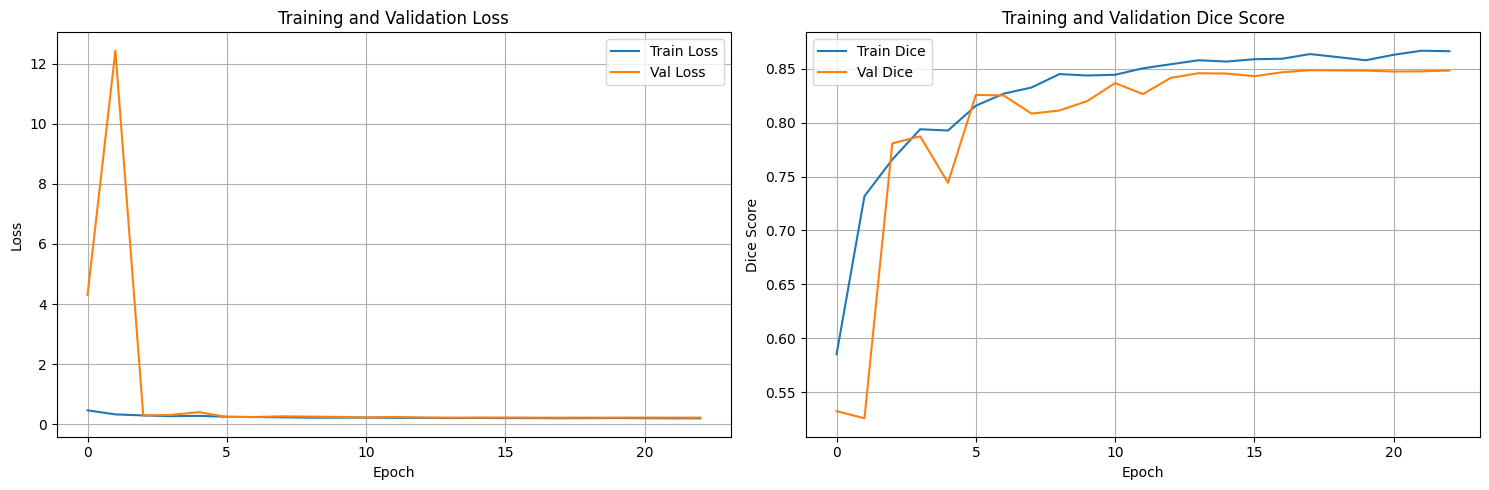

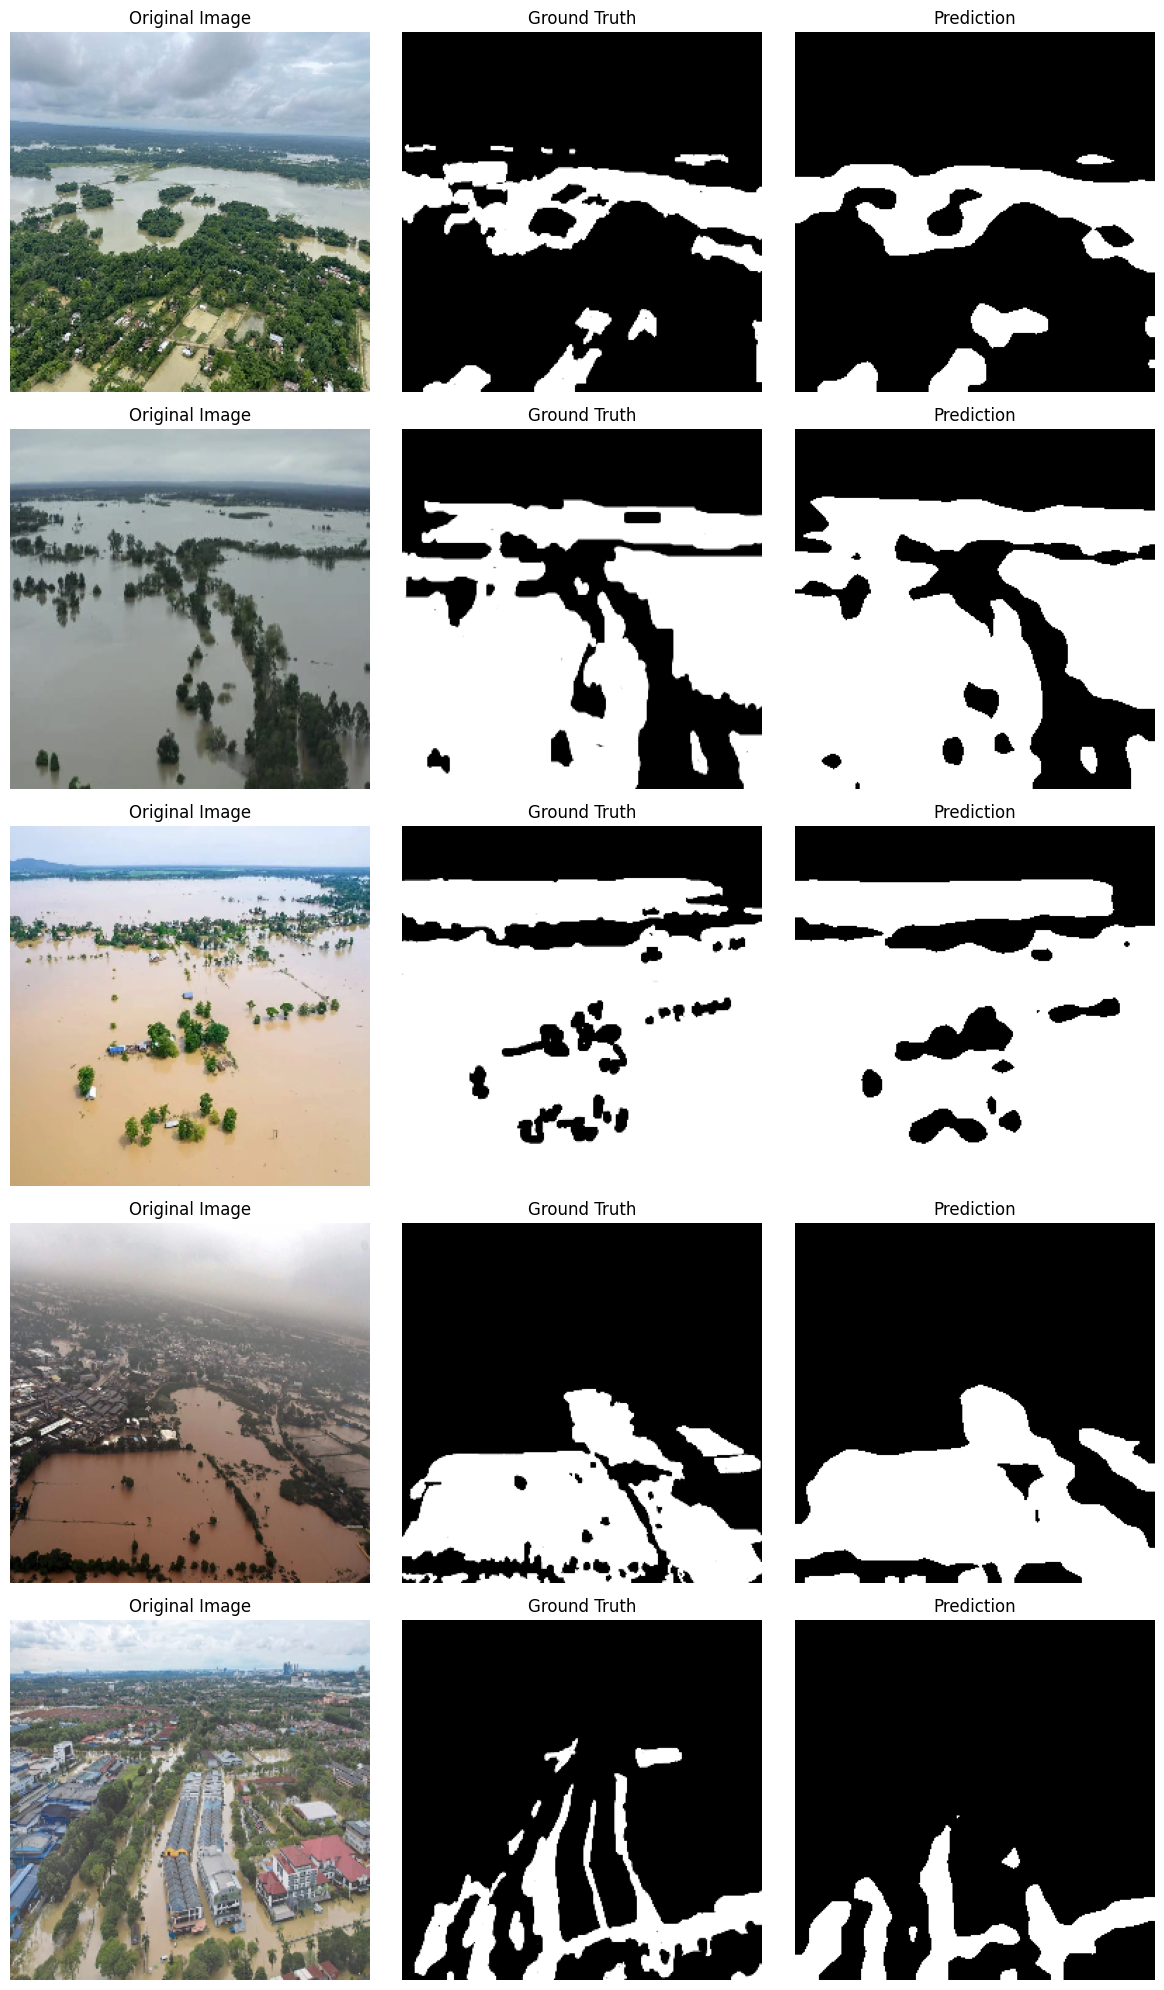

In [ ]:
model = DeepLabV3Plus(num_classes=1, backbone="resnet101").to(device)
model_name="DeepLabV3Plus"
criterion = BoundaryAwareDiceBCELoss(dice_weight=0.7, bce_weight=0.2, boundary_weight=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6)

model, history = train_model(
    model=model,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=params["epochs"],
)

test_loss_tta, test_dice_tta, all_predictions_tta, all_masks_tta = evaluate_model(model, test_loader, criterion, use_tta=False, use_crf=True, device=params["device"])
model.load_state_dict(torch.load(f"best_model_{model_name}.pth"))
plot_training_history(history)
visualize_predictions(model, test_loader, num_samples=5)

Analyzing performance distribution: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


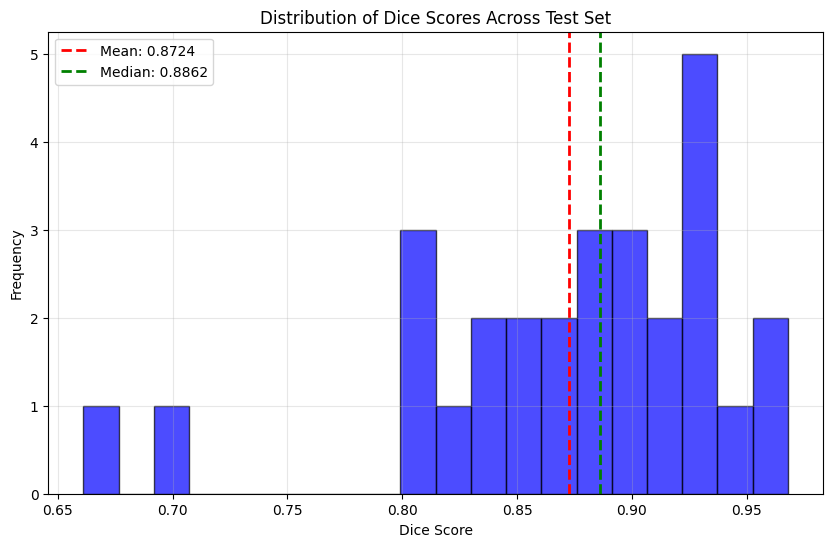

Dice Score Statistics:
Mean: 0.8724
Median: 0.8862
Min: 0.6612
Max: 0.9679
Std Dev: 0.0707


Analyzing model performance: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


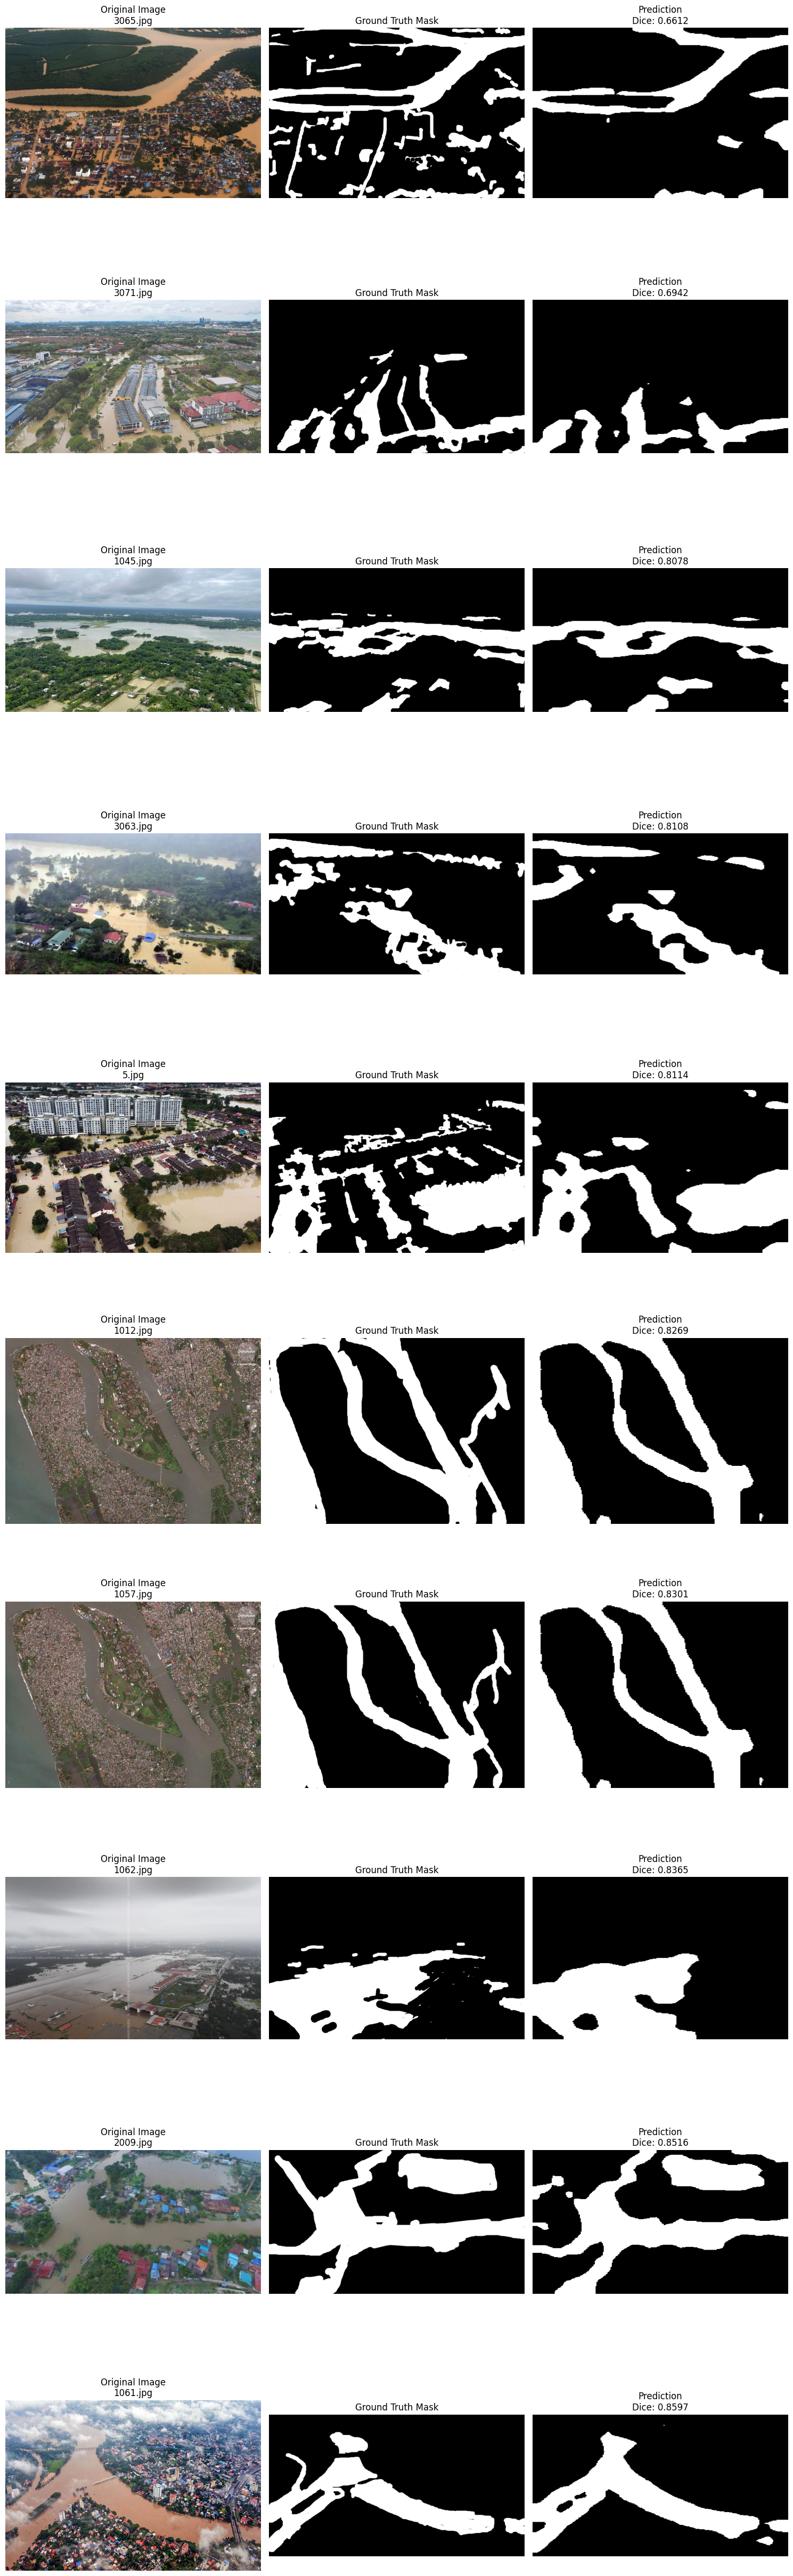

In [ ]:
def analyze_worst_performance(model, test_loader, num_samples=5, device=params["device"]):
    model.eval()
    sample_dice_scores = []
    
    with torch.no_grad():
        for images, masks, image_paths, mask_paths in tqdm(test_loader, desc="Analyzing model performance"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        
            for i in range(images.size(0)):
                sample_pred = outputs[i:i+1]
                sample_mask = masks[i:i+1].unsqueeze(1) if len(masks.shape) == 3 else masks[i:i+1]
                dice_score = dice_coefficient(sample_pred, sample_mask).item()
                
                sample_dice_scores.append((image_paths[i], mask_paths[i], dice_score))
    
    sample_dice_scores.sort(key=lambda x: x[2]) # sort by dice score, ascending
    worst_samples = sample_dice_scores[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    for i, (image_path, mask_path, dice_score) in enumerate(worst_samples):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        transform = test_transform
        transformed = transform(image=image, mask=mask)
        image_tensor = transformed["image"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(image_tensor)
            if isinstance(prediction, dict) and 'logits' in prediction:
                prediction = prediction['logits']
                prediction = torch.sigmoid(prediction)
            
            prediction = (prediction > 0.5).float()
            prediction = prediction[0, 0].cpu().numpy()
        
        if prediction.shape != mask.shape:
            prediction = cv2.resize(prediction, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original Image\n{os.path.basename(image_path)}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(prediction, cmap="gray")
        axes[i, 2].set_title(f"Prediction\nDice: {dice_score:.4f}")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return worst_samples

def analyze_performance_distribution(model, test_loader, device=params["device"]):
    model.eval()
    all_dice_scores = []
    
    with torch.no_grad():
        for images, masks, _, _ in tqdm(test_loader, desc="Analyzing performance distribution"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            if isinstance(outputs, dict) and 'logits' in outputs:
                outputs = outputs['logits']
                outputs = torch.sigmoid(outputs)
            
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            for i in range(images.size(0)):
                sample_pred = outputs[i:i+1]
                sample_mask = masks[i:i+1].unsqueeze(1) if len(masks.shape) == 3 else masks[i:i+1]
                dice_score = dice_coefficient(sample_pred, sample_mask).item()
                all_dice_scores.append(dice_score)
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_dice_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(np.mean(all_dice_scores), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(all_dice_scores):.4f}')
    plt.axvline(np.median(all_dice_scores), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(all_dice_scores):.4f}')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Dice Scores Across Test Set')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Dice Score Statistics:")
    print(f"Mean: {np.mean(all_dice_scores):.4f}")
    print(f"Median: {np.median(all_dice_scores):.4f}")
    print(f"Min: {np.min(all_dice_scores):.4f}")
    print(f"Max: {np.max(all_dice_scores):.4f}")
    print(f"Std Dev: {np.std(all_dice_scores):.4f}")
    
    return all_dice_scores

model.load_state_dict(torch.load(f"best_model_{model_name}.pth"))
dice_scores = analyze_performance_distribution(model, test_loader)
worst_samples = analyze_worst_performance(model, test_loader, num_samples=10)

Based on the worst-performing cases, I can say that those are the cases where the model performs poorly:
- river with compex shapes (e.g. `1069.jpg` and `34.jpg`), the model fragments the river bodies and misses significant sections
- small water bodies or fine details are often missed, likely due to downsampling operations in the encoder architecture; also maybe boundary-aware loss components like Boundary IoU or Hausdorff distance could help
- model performs bad on muddy/brown water; a possible solution is data augmentation to include more color variations

Also, `1010.jpg` ground truth mask looks kinda sus...

In some cases, I would say that the model performs even better than the ground truth masks -- it clearly captures water where it is. And if I correctly remember from the class, it is accepted to clean the data. 
So i said bye to: `21.jpg, 34.jpg, 1005.jpg, 1010.jpg, 1022.jpg, 1027.jpg, 1035.jpg, 1038.jpg, 1040.jpg, 1079.jpg, 2023.jpg, 2026.jpg, 2053.jpg, 2052.jpg, 3051.jpg, 3088.jpg`.

I experimented with DeepLabV3+ using different backbones: deeplabv3_resnet50, deeplabv3_resnet101, and deeplabv3_mobilenet_v3_large. DeepLabV3+ with deeplabv3_resnet101 backbone performed the best, offering an optimal balance between model capacity and generalization given our dataset size.

Main improvemnt that i have captured came from:
- removing problematic images;
- proper data augmentations to resolve cases where model underperformes (e.g. muddy/brown water -> introducing color variations in augmenations);
- moving from DiceLoss to DiceBCELoss to to a boundary-aware combination (BoundaryAwareDiceBCELoss with weights of 0.7, 0.2, and 0.1 respectively), as it helped model to focus challenging boundary regions;
- regarding the scheduler, ReduceLROnPlateau showed the best results
- also i have tried test-time augmentation, though it made the results even worse, maybe refinemnt is needed, i will leave it for the future work; but the thing that helped a lot at test time is crf.

Overall DeepLabV3+ with ResNet101 backbone achieved a test dice score of `0.9104` after applying CRF post-processing, so i consider the task done.

## Future work

- try SegFormer, SegNeXt, FPN etc.
- ensemble models: DeepLabV3+, SegFormer, FPN etc.
- apply better post-processing to refine boundaries
- refine test-time augmentation
- some fancy loss as explained in error analysis 